# Feature Selection and CRO

In this notebook, we will show an example of how to use CRO to evolve feature selection masks in the GHEODE methodology.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gheode_methodology.utils import filter_dataset
from gheode_methodology.plots import plot_solution_array
from PyCROSL.CRO_SL import CRO_SL
from PyCROSL.AbsObjectiveFunc import AbsObjectiveFunc
from PyCROSL.SubstrateInt import SubstrateInt

In [36]:
df = pd.read_csv("../data/dataframe_lag-1_K-20_no-cnorm.csv")
df

,msl_cc_0,msl_cc_1,msl_cc_2,msl_cc_3,msl_cc_4,msl_cc_5,msl_cc_6,msl_cc_7,msl_cc_8,msl_cc_9,...,r_zi_4,r_zi_5,r_zi_6,r_zi_7,r_zi_8,season_spring,season_summer,season_fall,season_winter,target_tp
0,102774.555,101606.375,98541.695,101836.300,99910.760,100295.000,100460.020,99184.375,101447.875,98987.920,...,68.434320,66.696840,59.167236,62.127750,68.537285,9.479582e-01,6.170754e-09,1.837852e-24,2.504413e-47,10.838032
1,102459.890,101584.625,99628.336,101911.490,100081.980,98412.050,100312.020,98978.260,101578.240,99226.920,...,66.899610,65.824780,71.189850,69.310520,62.125670,2.006828e+00,4.793381e-08,5.238380e-23,2.619240e-45,25.507689
2,102349.240,101803.770,98930.180,101894.990,99196.650,100259.836,100020.010,99459.800,101498.125,98302.250,...,67.228530,63.367638,71.111580,69.913960,71.185570,3.844160e+00,3.369117e-07,1.350996e-21,2.478650e-43,23.490190
3,102926.700,101689.390,99140.150,101886.310,99155.920,101464.040,99953.580,99241.080,101454.734,98632.950,...,60.181490,61.059868,61.021870,60.930157,58.795002,6.662902e+00,2.142698e-06,3.152693e-20,2.122392e-41,5.053043
4,102328.960,101663.460,100456.830,101808.450,99623.490,102716.390,100536.350,99358.260,101338.950,98710.230,...,44.702656,39.775370,31.059680,29.233988,27.226520,1.044951e+01,1.233037e-05,6.657020e-19,1.644397e-39,42.358400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,102507.270,101810.750,99068.060,101762.170,98799.305,101092.680,99126.300,98299.336,101412.920,97048.560,...,61.932987,60.554268,60.000250,60.375908,59.757930,5.834378e-26,7.187951e-10,4.051715e-01,1.044951e+01,51.557064
2238,102261.740,101758.195,99227.620,101880.180,98722.750,101230.040,99360.040,98416.890,101535.336,97774.830,...,69.912476,72.905800,67.913280,71.166680,70.885010,1.675904e-27,7.576044e-11,1.566964e-01,1.482856e+01,36.154747
2239,103018.760,101737.760,99095.070,101949.290,98030.350,99875.266,98778.375,99664.710,101689.150,96022.040,...,68.518060,59.579770,68.117645,68.000570,65.350370,4.355863e-29,7.225210e-12,5.483400e-02,1.904025e+01,11.286259
2240,102185.870,101826.180,99705.055,102001.664,99230.130,101261.820,100426.080,99764.640,101544.945,97012.445,...,28.756506,29.183332,35.088260,34.982582,34.433987,1.024401e-30,6.234893e-13,1.736246e-02,2.212161e+01,12.233257


In [37]:
# number of clusters
K = 20
# attributes to use from the DataFrame
attr_names = ["msl", "sst", "t2m", "r"]
n_attrs = len(attr_names)

## Creating ML helper functions

To calculate the fitness of a certain solution, we need to train a ML model and calculate its out-of-sample metric on the data. 

Ideally we would run the entire HundredHammers procedure, however this is too costly and would make the process run forever. Instead in this notebook we will use a simple Linear Regression and let the fitness be the MSE of the model. 

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold

In [39]:
def get_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    return X, y

In [40]:
def get_train_test(df, random_state=0):
    X, y = get_X_y(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [41]:
def get_mse(df, model=LinearRegression(), simulations=10):
    errors_train = []
    errors_test = []
    errors_cv_train = []
    errors_cv_test = []

    for i in range(simulations):
        X_train, X_test, y_train, y_test = get_train_test(df, random_state=i)

        model.fit(X_train, y_train)

        error_train = mean_squared_error(y_train, model.predict(X_train))
        error_test = mean_squared_error(y_test, model.predict(X_test))

        cv_results = cross_validate(model, X_train, y_train, 
                                    cv=KFold(10, shuffle=True, random_state=i*2),
                                    scoring="neg_mean_squared_error", 
                                    return_train_score=True)
        error_cv_train = - cv_results["train_score"].mean()
        error_cv_val = - cv_results["test_score"].mean()

        errors_train.append(error_train)
        errors_test.append(error_test)
        errors_cv_train.append(error_cv_train)
        errors_cv_test.append(error_cv_val)

    return np.array(errors_train).mean(), np.array(errors_cv_train).mean(), np.array(errors_cv_test).mean(), np.array(errors_test).mean()

## Running a single CRO experiment

With the fitness function defined, we are ready to run CRO on the problem.

In [42]:
from PyCROSL.CRO_SL import CRO_SL
from PyCROSL.AbsObjectiveFunc import AbsObjectiveFunc
from PyCROSL.SubstrateInt import SubstrateInt

In [43]:
class LinearRegressionMse(AbsObjectiveFunc):
    def __init__(self, size, K, attr_names,
                 lag_time_max=4, lag_time_min=0,
                 time_step_max=4, time_step_min=1,
                 fitness_simulations=10):
        
        self.size = size
        self.K = K
        self.attr_names = attr_names
        self.lag_time_max = lag_time_max
        self.lag_time_min = lag_time_min
        self.time_step_max = time_step_max
        self.time_step_min = time_step_min
        self.fitness_simulations = fitness_simulations

        self.lag_time_size = (size - K) // 2
        self.time_step_size = (size - K) // 2
        self.mask_size = K
        self.opt = "min"

        self.sup_lim = np.concatenate((np.full(self.lag_time_size, self.lag_time_max + 1),
                                       np.full(self.time_step_size, self.time_step_max + 1),
                                       np.full(self.mask_size, 2)))
        self.inf_lim = np.concatenate((np.full(self.lag_time_size, self.lag_time_min),
                                       np.full(self.time_step_size, self.time_step_min),
                                       np.full(self.mask_size, 0)))

        super().__init__(self.size, self.opt, self.sup_lim, self.inf_lim)

    def convert_solution_to_data(self, solution):
        lag_times = np.reshape(solution[:self.lag_time_size], (n_attrs, K))
        time_steps = np.reshape(solution[self.lag_time_size:(self.lag_time_size + self.time_step_size)], (n_attrs, K))
        masks = np.reshape(solution[(self.lag_time_size + self.time_step_size):], K)

        return lag_times, time_steps, masks

    def objective(self, solution):
        data = filter_dataset(df, self.K, self.attr_names,
                              *self.convert_solution_to_data(solution),
                              agg_method="cm",
                              cols_to_maintain=["season_spring", "season_summer",
                                                "season_fall", "season_winter",
                                                "target_tp"])
        
        lr = LinearRegression()
        X, y = get_X_y(data)
        
        test_mse = []
        for i in range(self.fitness_simulations):
            X_train, X_test, y_train, y_test = get_train_test(data, random_state=i)
            lr.fit(X_train, y_train)
            test_mse.append(mean_squared_error(y_test, lr.predict(X_test)))
        
        return np.array(test_mse).mean()

    def random_solution(self):
        lag_times = np.random.randint(self.lag_time_min, self.lag_time_max + 1, self.lag_time_size)
        time_steps = np.random.randint(self.time_step_min, self.time_step_max + 1, self.time_step_size)
        masks = np.random.randint(0, 2, self.mask_size)
        return np.concatenate((lag_times, time_steps, masks))

    def repair_solution(self, solution):
        return np.clip(solution, self.inf_lim, self.sup_lim)

In [44]:
LinearRegressionMse((n_attrs * K) * 2 + K, K, attr_names).random_solution()

array([0, 1, 1, 2, 1, 3, 2, 1, 3, 0, 1, 3, 0, 2, 3, 2, 3, 1, 3, 4, 4, 3,
       4, 2, 0, 1, 2, 1, 3, 3, 2, 0, 4, 3, 4, 4, 3, 2, 3, 0, 1, 3, 3, 3,
       1, 2, 3, 4, 4, 3, 2, 3, 3, 2, 0, 2, 4, 3, 0, 3, 3, 4, 3, 2, 0, 4,
       3, 0, 1, 1, 4, 2, 0, 1, 4, 1, 2, 4, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1,
       3, 4, 1, 3, 2, 1, 1, 4, 1, 4, 3, 2, 1, 2, 1, 4, 1, 3, 3, 1, 2, 2,
       1, 4, 2, 1, 2, 3, 1, 2, 2, 4, 3, 3, 4, 4, 4, 3, 4, 1, 2, 4, 4, 1,
       1, 3, 1, 4, 1, 4, 4, 2, 1, 4, 3, 2, 1, 4, 2, 1, 2, 3, 4, 1, 2, 2,
       1, 4, 4, 3, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0])

In [45]:
params = {
    "popSize": 100,
    "rho": 0.6,
    "Fb": 0.98,
    "Fd": 0.2,
    "Pd": 0.8,
    "k": 3,
    "K": 20,
    "group_subs": True,

    "stop_cond": "time_limit",
    "time_limit": 60.0,
    "Ngen": 10000,
    "Neval": 10000,
    "fit_target": 1000,

    "verbose": True,
    "v_timer": 1,
    "Njobs": 1,

    "dynamic": True,
    "dyn_method": "success",
    "dyn_metric": "avg",
    "dyn_steps": 10,
    "prob_amp": 0.01
}

In [46]:
objfunc = LinearRegressionMse((n_attrs * K) * 2 + K, K, attr_names)
operators = [
    SubstrateInt("DE/rand/1", {"F": 0.7, "Cr":0.8}),
    SubstrateInt("DE/best/2", {"F": 0.7, "Cr":0.8}),
    SubstrateInt("DE/current-to-best/1", {"F": 0.7, "Cr":0.8}),
    SubstrateInt("DE/current-to-rand/1", {"F": 0.7, "Cr":0.8})
]

In [47]:
cro = CRO_SL(objfunc, operators, params)

In [48]:
solution, obj_value = cro.optimize()

Starting optimization of Some Function
--------------------------------------
Optimizing Some Function:
	Time Spent: 8.81s
	Generation: 0
	Best fitness: 313.6744168401663
	Evaluations of fitness: 60
	Substrate probability:
		DE/rand/1:           0.25
		DE/best/2:           0.25
		DE/current-to-best/1:0.25
		DE/current-to-rand/1:0.25
Optimizing Some Function:
	Time Spent: 19.79s
	Generation: 1
	Best fitness: 301.13825440970425
	Evaluations of fitness: 205
	Substrate probability:
		DE/rand/1:           0.410835
		DE/best/2:           0.113189
		DE/current-to-best/1:0.410835
		DE/current-to-rand/1:0.065142
Optimizing Some Function:
	Time Spent: 24.57s
	Generation: 2
	Best fitness: 299.8609506524248
	Evaluations of fitness: 288
	Substrate probability:
		DE/rand/1:           0.013251
		DE/best/2:           0.895471
		DE/current-to-best/1:0.082584
		DE/current-to-rand/1:0.008695
Optimizing Some Function:
	Time Spent: 29.05s
	Generation: 3
	Best fitness: 299.6644750873563
	Evaluations of fitn

In [49]:
print(solution)

[5 0 4 0 2 1 1 0 0 4 0 4 0 0 0 1 0 0 5 0 0 0 3 2 0 0 0 3 4 3 4 0 0 0 0 5 3
 5 5 0 1 0 5 1 2 5 4 0 4 5 0 0 4 3 0 5 0 5 0 0 5 3 0 1 0 0 0 0 3 3 0 0 3 2
 5 0 0 2 4 0 5 3 3 1 3 1 1 5 3 1 5 3 2 1 1 3 1 4 1 1 2 2 5 1 2 1 1 4 5 4 5
 3 5 1 5 2 1 5 4 1 1 4 2 1 1 2 1 3 1 4 5 1 3 2 2 4 5 3 1 1 1 3 1 1 1 1 1 3
 5 3 3 1 2 3 1 1 2 2 1 2 0 0 0 0 0 0 2 0 0 0 0 1 0 0 2 0 0 1 0 0]


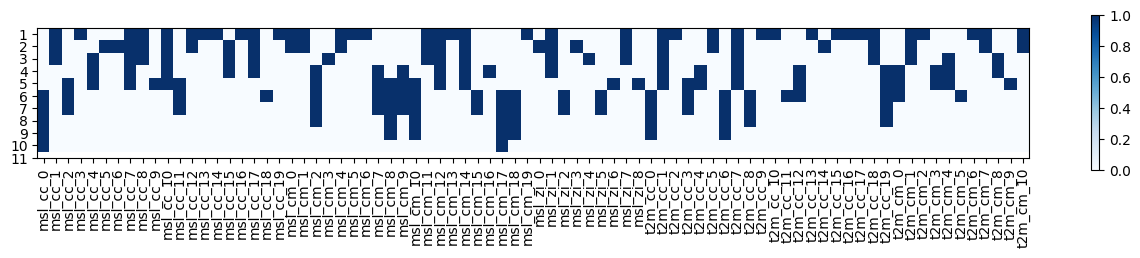

In [54]:
plot_solution_array(df, np.array([solution]), K, len(attr_names), should_mask=False)

Finished optimizing Some Function
Number of generations: 13
Real time spent: 60.10955s
CPU time spent: 71.23438s
Number of fitness evaluations: 1096
	Substrate probability:
		DE/rand/1:           0.004902
		DE/best/2:           0.495098
		DE/current-to-best/1:0.004902
		DE/current-to-rand/1:0.495098
Best fitness: 288.3479930355109


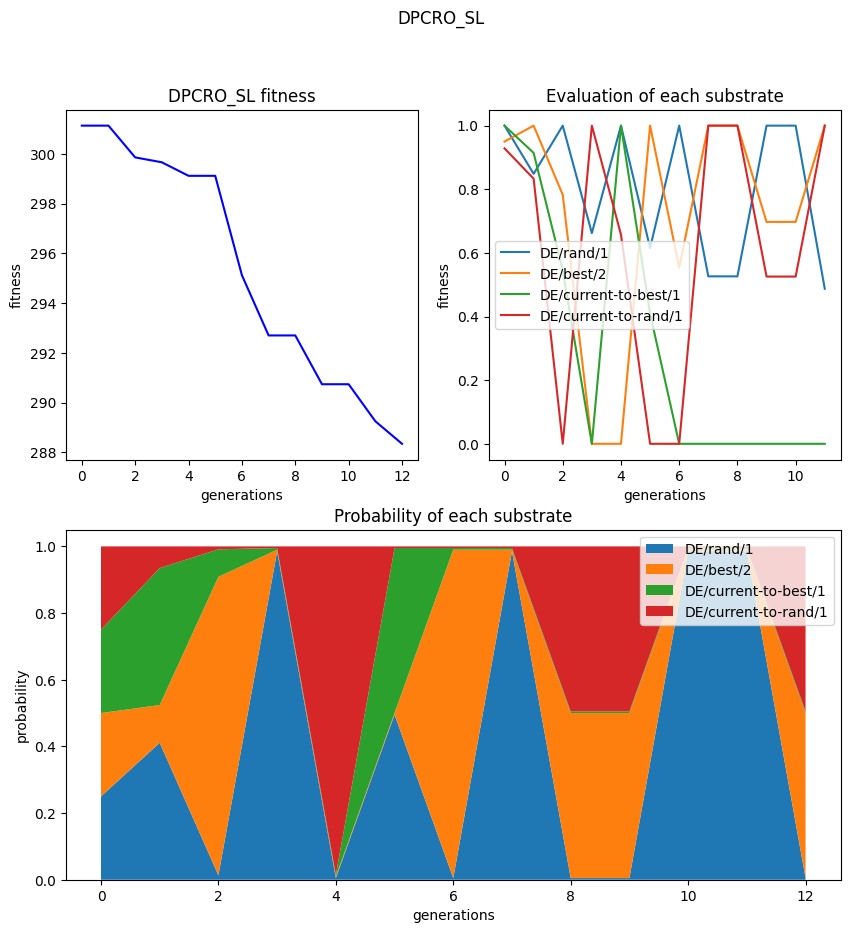

In [53]:
cro.display_report()

## Running multiple CRO experiments

Evidently, the best way to eliminate noise is to run several CRO experiments and average the results. For example:

In [55]:
solutions, obj_values = [], []
for _ in range(10):
    cro = CRO_SL(objfunc, operators, params)
    solution, obj_value = cro.optimize()
    
    solutions.append(solution)
    obj_values.append(obj_value)

Starting optimization of Some Function
--------------------------------------
Optimizing Some Function:
	Time Spent: 9.33s
	Generation: 0
	Best fitness: 309.20178206151627
	Evaluations of fitness: 1156
	Substrate probability:
		DE/rand/1:           0.25
		DE/best/2:           0.25
		DE/current-to-best/1:0.25
		DE/current-to-rand/1:0.25
Optimizing Some Function:
	Time Spent: 22.31s
	Generation: 1
	Best fitness: 300.3083813531904
	Evaluations of fitness: 1292
	Substrate probability:
		DE/rand/1:           0.475747
		DE/best/2:           0.475747
		DE/current-to-best/1:0.01067
		DE/current-to-rand/1:0.037835
Optimizing Some Function:
	Time Spent: 26.96s
	Generation: 2
	Best fitness: 298.3492164627222
	Evaluations of fitness: 1375
	Substrate probability:
		DE/rand/1:           0.133426
		DE/best/2:           0.097965
		DE/current-to-best/1:0.004902
		DE/current-to-rand/1:0.763707
Optimizing Some Function:
	Time Spent: 30.4s
	Generation: 3
	Best fitness: 291.0945725465296
	Evaluations of fi

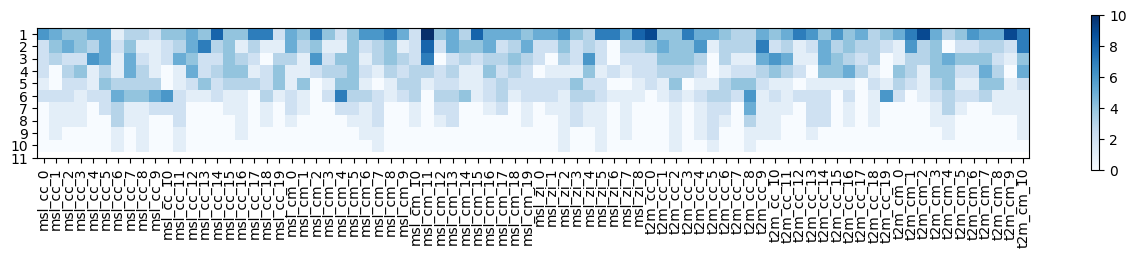

In [58]:
plot_solution_array(df, np.array(solutions), K, len(attr_names), should_mask=False)